## Import packages

In [82]:
import gzip
import json
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from datetime import datetime
sns.set()
sns.set_context('talk')

In [83]:
def parse(path):
    g = gzip.open(path, 'r')
    for l in g:
        l = str(json.loads(l))
        yield eval(l)

## Import dataset

In [84]:
data_modcloth = []
for l in parse("modcloth_final_data.json.gz"):
    data_modcloth.append(l)

In [85]:
data_modcloth[0]

{'item_id': '123373',
 'waist': '29',
 'size': 7,
 'quality': 5,
 'cup size': 'd',
 'hips': '38',
 'bra size': '34',
 'category': 'new',
 'bust': '36',
 'height': '5ft 6in',
 'user_name': 'Emily',
 'length': 'just right',
 'fit': 'small',
 'user_id': '991571'}

In [86]:
data_renttherunway = []
for l in parse("renttherunway_final_data.json.gz"):
    data_renttherunway.append(l)

In [87]:
data_renttherunway[0]

{'fit': 'fit',
 'user_id': '420272',
 'bust size': '34d',
 'item_id': '2260466',
 'weight': '137lbs',
 'rating': '10',
 'rented for': 'vacation',
 'review_text': "An adorable romper! Belt and zipper were a little hard to navigate in a full day of wear/bathroom use, but that's to be expected. Wish it had pockets, but other than that-- absolutely perfect! I got a million compliments.",
 'body type': 'hourglass',
 'review_summary': 'So many compliments!',
 'category': 'romper',
 'height': '5\' 8"',
 'size': 14,
 'age': '28',
 'review_date': 'April 20, 2016'}

In [88]:
len(data_renttherunway)

192544

## Data Clean

In [89]:
df = pd.DataFrame(data_renttherunway)

In [90]:
def standardize_height(str_in):
    if type(str_in) == float:
        return str_in
    str_in = str_in.strip()
    if '\'' in str_in:
        str_in = str_in.replace('\'', '')
    if '"' in str_in:
        str_in = str_in.replace('"', '')

    foot,inch = str_in.strip().split(' ')
    output = int(foot) * 12 + int(inch)

    return output

In [91]:
def standardize_weight(str_in):
    if type(str_in) == float:
        return str_in
    if 'lbs' in str_in:
        str_in = str_in.replace('lbs', '')
    if(str_in.isnumeric()):
        return int(str_in)

    return str_in

In [92]:
rating_dict = {'2':1, '4':2, '6':3, '8':4, '10':5}

In [93]:
df['height'] = df['height'].apply(lambda x: standardize_height(x))
df['weight'] = df['weight'].apply(lambda x: standardize_weight(x))
df['fit'] = df['fit'].apply(lambda x: x == 'fit')
df['review_date'] = df['review_date'].apply(lambda x: datetime.strptime(x, '%B %d, %Y'))
df['rating'] = df['rating'].apply(lambda x: rating_dict[x] if type(x) == str else x)

In [94]:
df.head()

,fit,user_id,bust size,item_id,weight,rating,rented for,review_text,body type,review_summary,category,height,size,age,review_date
0,True,420272,34d,2260466,137.0,5.0,vacation,An adorable romper! Belt and zipper were a lit...,hourglass,So many compliments!,romper,68.0,14,28,2016-04-20
1,True,273551,34b,153475,132.0,5.0,other,I rented this dress for a photo shoot. The the...,straight & narrow,I felt so glamourous!!!,gown,66.0,12,36,2013-06-18
2,True,360448,NaN,1063761,NaN,5.0,party,This hugged in all the right places! It was a ...,NaN,It was a great time to celebrate the (almost) ...,sheath,64.0,4,116,2015-12-14
3,True,909926,34c,126335,135.0,4.0,formal affair,I rented this for my company's black tie award...,pear,Dress arrived on time and in perfect condition.,dress,65.0,8,34,2014-02-12
4,True,151944,34b,616682,145.0,5.0,wedding,I have always been petite in my upper body and...,athletic,Was in love with this dress !!!,gown,69.0,12,27,2016-09-26


## Exploratory Data Analysis

In [95]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 192544 entries, 0 to 192543
Data columns (total 15 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   fit             192544 non-null  bool          
 1   user_id         192544 non-null  object        
 2   bust size       174133 non-null  object        
 3   item_id         192544 non-null  object        
 4   weight          162562 non-null  float64       
 5   rating          192462 non-null  float64       
 6   rented for      192534 non-null  object        
 7   review_text     192544 non-null  object        
 8   body type       177907 non-null  object        
 9   review_summary  192544 non-null  object        
 10  category        192544 non-null  object        
 11  height          191867 non-null  float64       
 12  size            192544 non-null  int64         
 13  age             191584 non-null  object        
 14  review_date     192544 non-null  dat

In [96]:
df.describe()

,weight,rating,height,size
count,162562.000000,192462.000000,191867.000000,192544.000000
mean,137.391709,4.546186,65.310621,12.245175
std,21.899967,0.715022,2.663480,8.494877
min,50.000000,1.000000,54.000000,0.000000
25%,123.000000,4.000000,63.000000,8.000000
50%,135.000000,5.000000,65.000000,12.000000
75%,148.000000,5.000000,67.000000,16.000000
max,300.000000,5.000000,78.000000,58.000000


### Heights

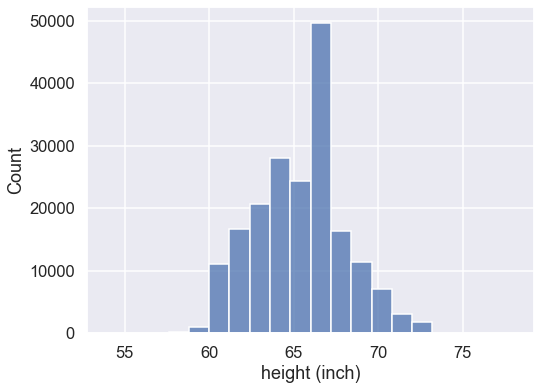

In [101]:
# overview of the whole distribution of height
plt.figure(figsize=(8, 6))
sns.histplot(data=df,x = 'height', bins=20)
plt.xlabel('height (inch)')
plt.show()

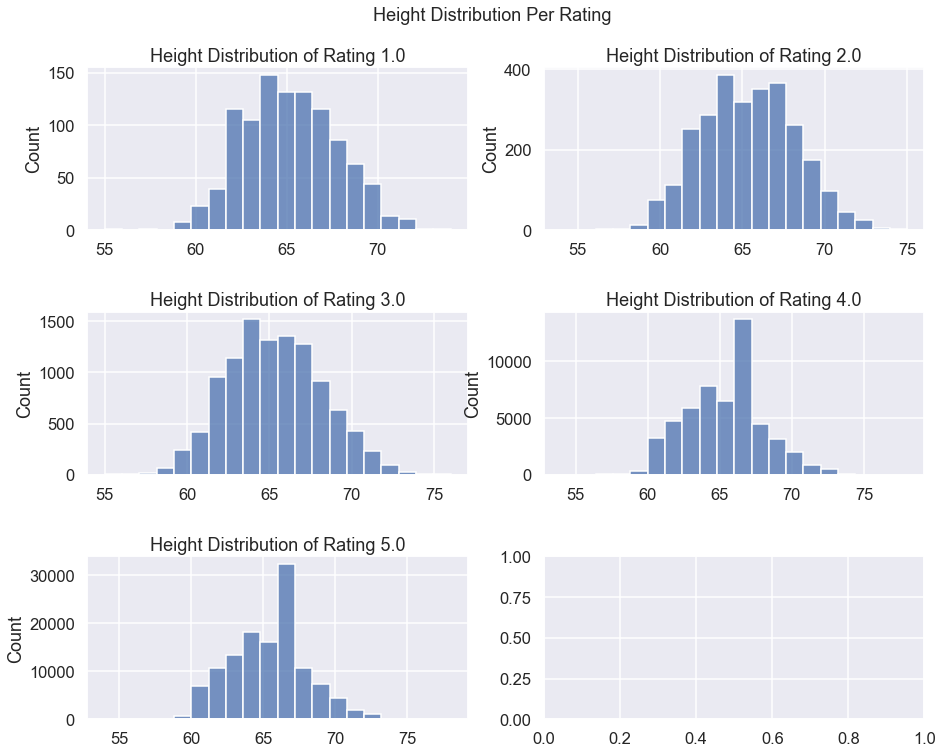

In [100]:
# define subplot grid
fig, axs = plt.subplots(nrows=3, ncols=2, figsize=(15, 12))
plt.subplots_adjust(hspace=0.5)
fig.suptitle("Height Distribution Per Rating", fontsize=18, y=0.95)

# loop through tickers and axes
for gb, ax in zip(df.groupby('rating'), axs.ravel()):
    rate, dfs = gb
    sns.histplot(data = dfs,x = 'height', bins=20, ax = ax)
    ax.set_title(f'Height Distribution of Rating {str(rate)}')
    ax.set_xlabel("")

plt.show()

In [52]:
df['rating']

0         10
1         10
2         10
3          8
4         10
          ..
192539    10
192540    10
192541     6
192542    10
192543    10
Name: rating, Length: 192544, dtype: object

### Weights

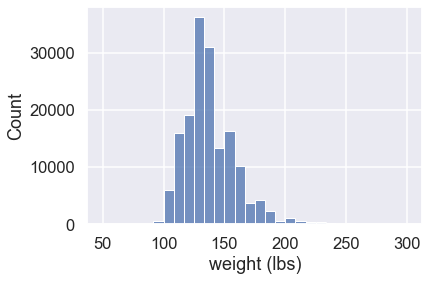

In [22]:
sns.histplot(data=df, x = 'weight', bins=30)
plt.xlabel('weight (lbs)')
plt.show()

### Category data

In [ ]:
rentedFor = []
for d in data_renttherunway:
    if d.get('rented for') not in rentedFor:
        rentedFor.append(d.get('rented for'))

In [ ]:
rentedFor

In [ ]:
bodyType = []
for d in data_renttherunway:
    if d.get('body type') not in bodyType:
        bodyType.append(d.get('body type'))

In [ ]:
bodyType

In [ ]:
category = []
for d in data_renttherunway:
    if d.get('category') not in category:
        category.append(d.get('category'))

In [ ]:
category